In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *

np.random.seed(123)

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [2]:
# define transform function to constrain parameter values
def transform(params):
    
    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = params
    
    # take exp of strictly positive parameters
    mu_max = jnp.exp2(mu_max) 
    pref = jnp.exp2(pref)*7.
    Sigma_inv = jnp.exp2(Sigma_inv)/10.
    K_inv = jnp.exp2(K_inv)/10.
    delta = jnp.exp2(delta)/10.
    gamma = gamma/10.
    
    return jnp.array([mu_max, pref, Sigma_inv, K_inv, delta, gamma])

# ode 
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = transform(params)
    
    # unpack variables
    od, pH = x 
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp2(-Sigma_inv * (pH - pref)**2.) - delta) 
    # dpH = (gamma * od) * (pH * (2. - pH / 7.))
    dpH = (gamma * dod) * (pH * (1. - pH / 14.))
    
    return jnp.array([dod, dpH])  

# define prior mean of untransformed variables 
prior_mean = np.array([0., 0., 0., 0., 0., 0.])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [3]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [4]:
df.describe()

,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,8.823529,6.284827,0.103395,0.024959,0.015209,0.018839,0.027583,0.016583,0.021769,0.002393,0.090695,0.079882,0.083556,0.097024
std,7.938535,1.033571,0.653701,0.278782,0.150054,0.180187,0.222743,0.208608,0.201716,0.009162,0.530186,0.463441,0.473807,0.582427
min,0.000000,4.976477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.152622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.168138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,7.337288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,8.150575,5.147123,4.072533,2.927829,2.700796,3.934214,3.976187,3.789218,0.075608,4.856178,4.326752,4.344400,5.313583


In [5]:
all_species = df.columns.values[3:]
all_species

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD'],
      dtype=object)

In [6]:
sp = all_species[7][:-3]
sp

'DF'

In [7]:
df_species = pd.concat([df_exp[['Treatments', 'Time', 'pH', sp+'_OD']] 
                   for exp_name, df_exp in df.groupby("Treatments") if sp in exp_name])
df_species

,Treatments,Time,pH,DF_OD
756,DF_pH4_0,0,5.003232,0.010000
757,DF_pH4_0,3,5.016297,0.010000
758,DF_pH4_0,6,5.046015,0.010000
759,DF_pH4_0,9,5.027032,0.010000
760,DF_pH4_0,12,5.018455,0.010000
...,...,...,...,...
859,DF_pH9_2,3,7.599856,0.029343
860,DF_pH9_2,6,7.548351,0.048898
861,DF_pH9_2,9,7.751730,0.031728
862,DF_pH9_2,12,7.730361,0.031251


## Specify system state variables 

In [8]:
# names of species
species = [sp+'_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [9]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_species, 
            sys_vars = species, 
            prior_mean = prior_mean,
               alpha=10.)

## Fit the parameter posterior

In [ ]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM()

print("Elapsed time {:.2f}s".format(time.time()-t0))

Trial 1
Loss: 33282.398
Loss: 6357.279
Loss: 766.632
Loss: 481.568
Loss: 454.107
Loss: 450.907
Loss: 450.603
Loss: 448.150
Loss: 444.290
Loss: 437.123
Loss: 435.237
Loss: 434.628
Loss: 434.516
Loss: 418.456
Loss: 414.520
Loss: 413.838
Loss: 407.299
Loss: 407.044
Loss: 397.541
Loss: 396.232
Loss: 385.911
Loss: 383.496
Loss: 378.947
Loss: 373.281
Loss: 369.932
Loss: 364.300
Loss: 364.106
Loss: 362.280
Loss: 359.153
Loss: 358.877
Loss: 356.419
Loss: 356.169
Loss: 355.777
Loss: 352.186
Loss: 351.835
Loss: 345.665
Loss: 343.062
Loss: 342.858
Loss: 329.300
Loss: 310.269
Loss: 275.376
Loss: 271.483
Loss: 265.088
Loss: 253.665
Loss: 236.800
Loss: 235.322
Loss: 233.196
Loss: 229.299
Loss: 222.942
Loss: 222.614
Loss: 222.114
Loss: 217.790
Loss: 217.669
Loss: 217.464
Loss: 217.142
Loss: 214.153
Loss: 213.416
Trial 2
Trial 3
Loss: 55110.086
Loss: 11133.657
Loss: 1983.842
Loss: 623.428
Loss: 478.907
Loss: 461.711
Loss: 439.535
Loss: 384.455
Loss: 367.693
Loss: 353.299
Loss: 352.180
Loss: 351.539
Lo

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 225.46it/s]


Updating posterior...
Epoch 1, NEG ELBO: 120.054
Epoch 2, NEG ELBO: 113.589
Epoch 3, NEG ELBO: 115.440
Epoch 4, NEG ELBO: 115.282
Epoch 5, NEG ELBO: 114.196
Epoch 6, NEG ELBO: 113.523
Epoch 7, NEG ELBO: 113.765
Epoch 8, NEG ELBO: 113.786
Epoch 9, NEG ELBO: 114.164
Epoch 10, NEG ELBO: 116.872
decrease lr to 9.000e-04
Epoch 11, NEG ELBO: 115.436, Slope: 0.001
decrease lr to 8.100e-04
Epoch 12, NEG ELBO: 114.687, Slope: 0.000
decrease lr to 7.290e-04
Epoch 13, NEG ELBO: 117.158, Slope: 0.002
decrease lr to 6.561e-04
Epoch 14, NEG ELBO: 115.331, Slope: 0.002
decrease lr to 5.905e-04
Epoch 15, NEG ELBO: 118.007, Slope: 0.004
decrease lr to 5.314e-04
Epoch 16, NEG ELBO: 115.216, Slope: 0.002
decrease lr to 4.783e-04
Epoch 17, NEG ELBO: 116.160, Slope: 0.002
decrease lr to 4.305e-04
Epoch 18, NEG ELBO: 117.064, Slope: 0.001
decrease lr to 3.874e-04
Epoch 19, NEG ELBO: 119.787, Slope: 0.002
decrease lr to 3.487e-04
Epoch 20, NEG ELBO: 121.983, Slope: 0.005
decrease lr to 3.138e-04
Epoch 21, NE

 21%|████████▌                               | 213/1000 [00:04<00:14, 53.85it/s]

In [187]:
# ode_model.estimate_evidence()

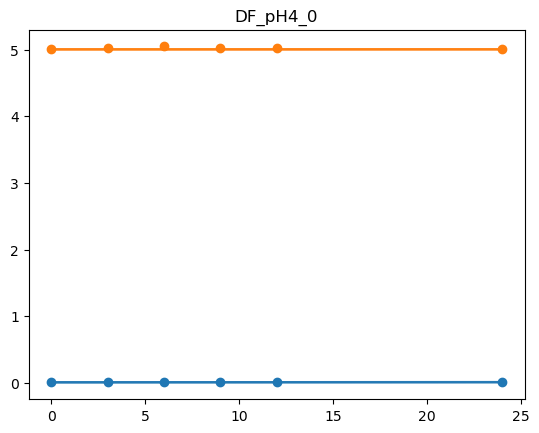

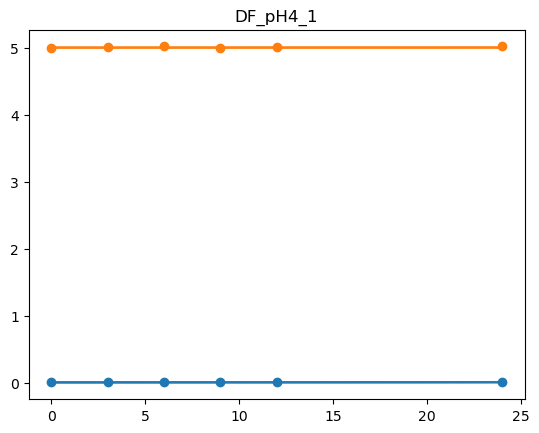

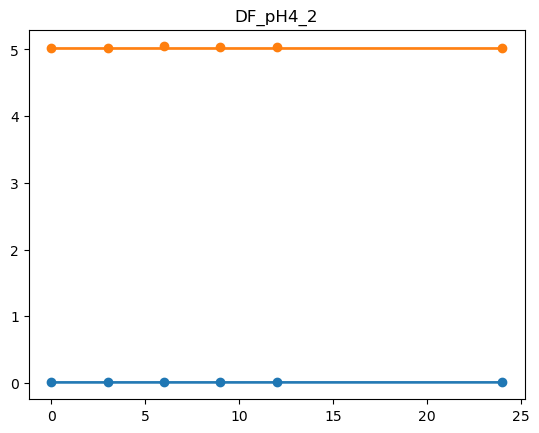

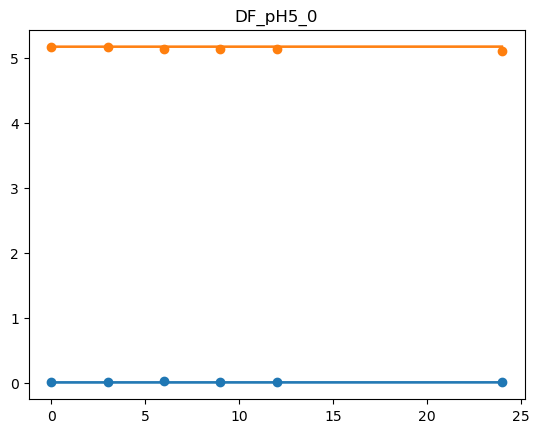

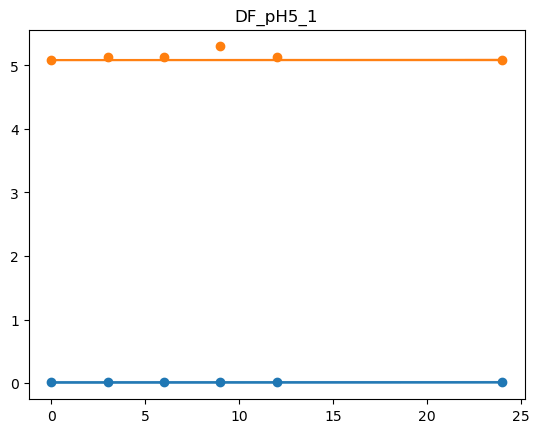

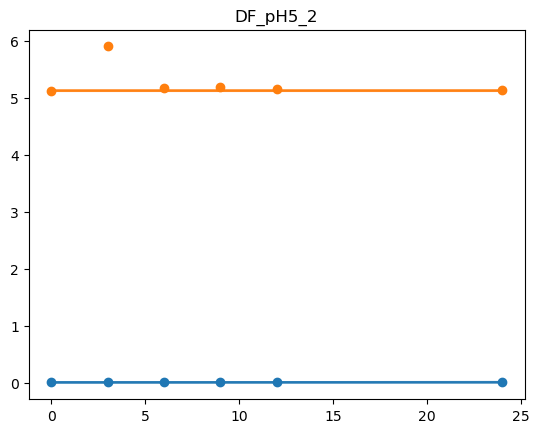

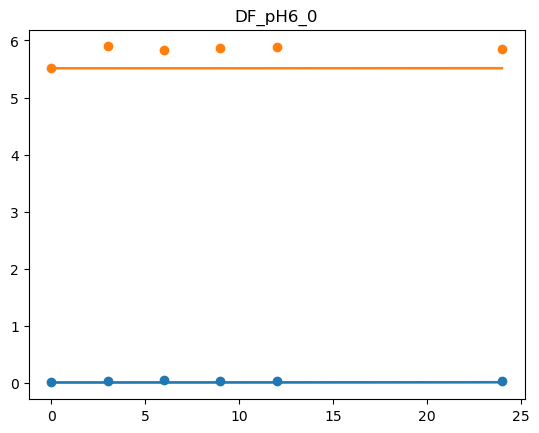

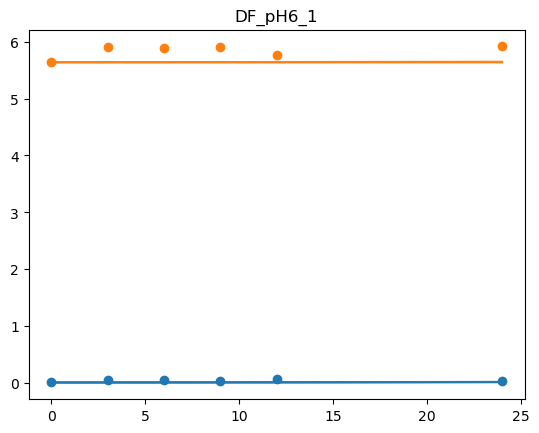

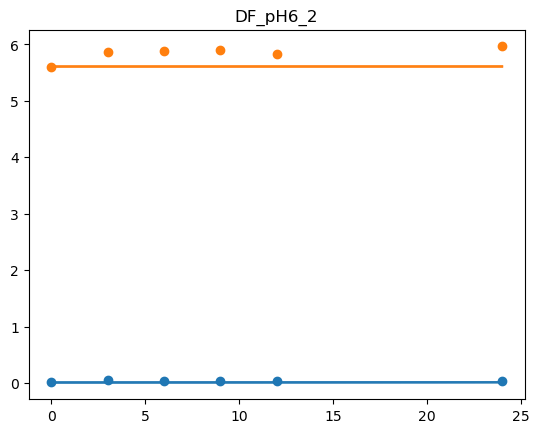

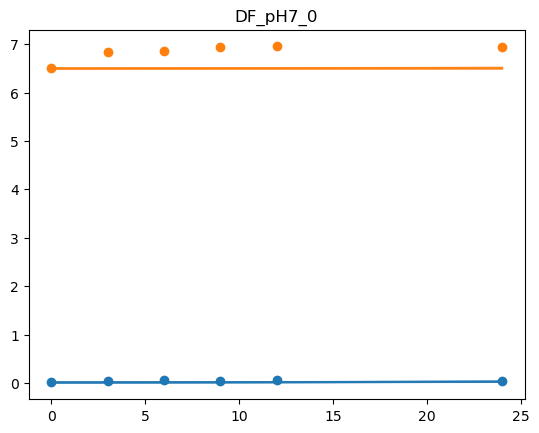

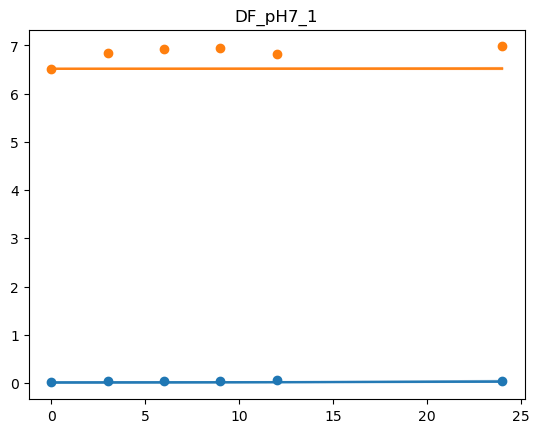

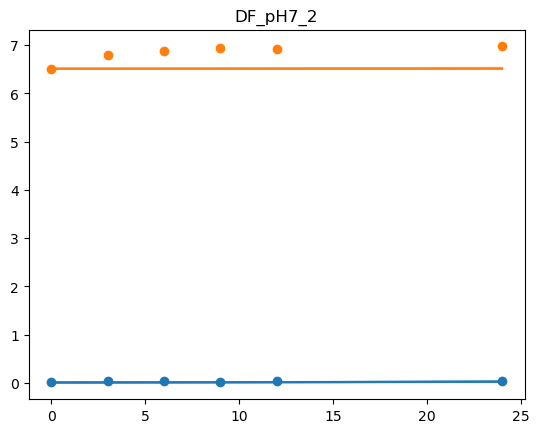

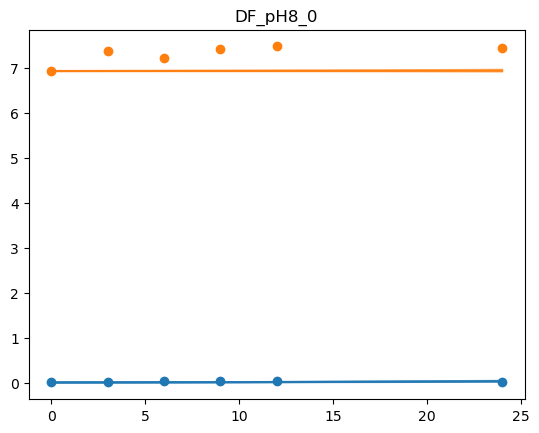

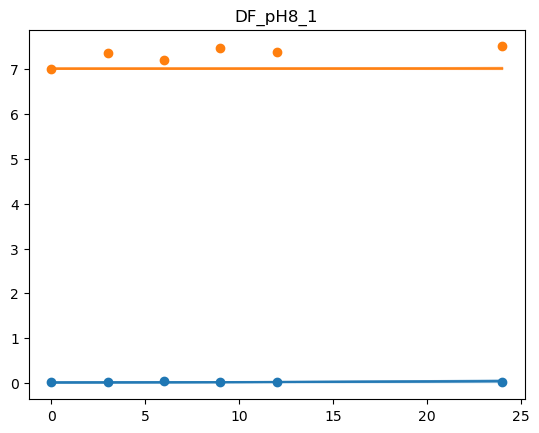

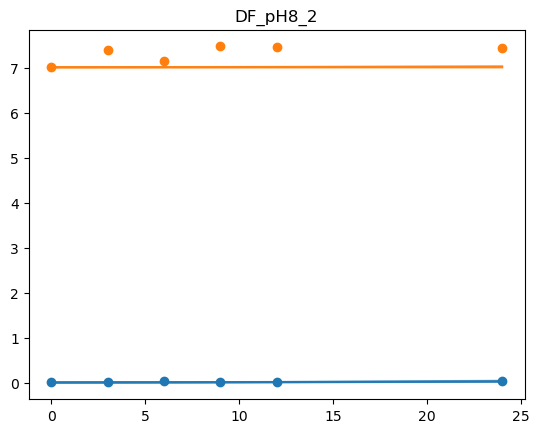

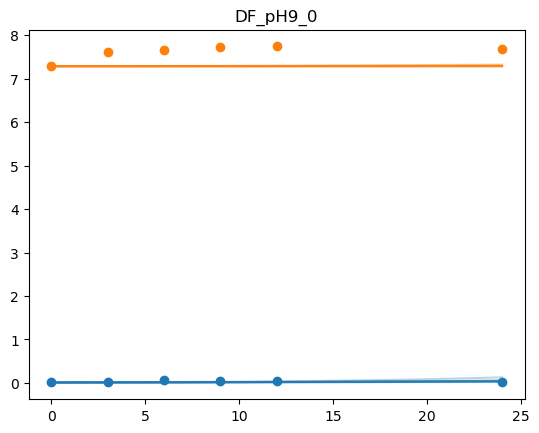

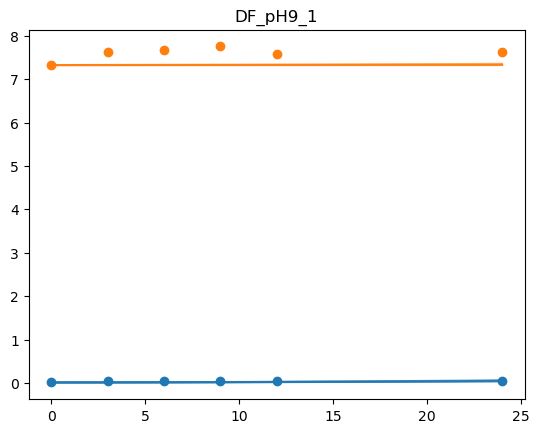

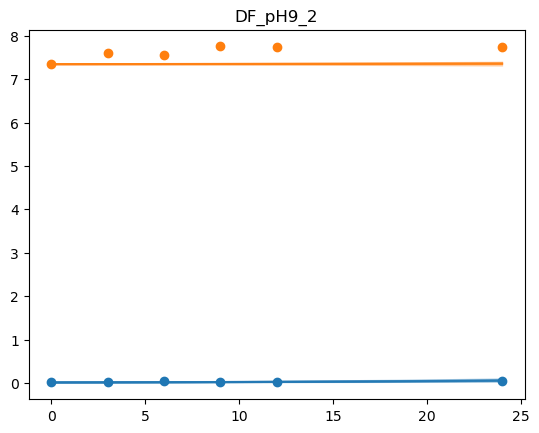

In [188]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_species.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    # y_preds = ode_model.predict_prior(x0, t_eval, n_sample=10)
    y_preds = ode_model.predict_sample(x0, t_eval, n_sample=10)
    
    # plot 
    for i, s in enumerate(species[:2]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

In [189]:
#ode_model.estimate_evidence(n_sample=1000, n_trials=3)

In [11]:
ode_model.param_df()

,mean,stdv
0,0.398438,0.047705
1,13.404348,0.208138
2,0.059612,0.004606
3,0.104060,0.080931
4,0.060311,0.017140
5,0.034681,0.083545


In [181]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params.to_csv('Fitting/'+sp+'_param.csv')